# Whale Classification: Data Collection

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

## Importing require dependencies and starting a spark context

In [2]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext, DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

In [3]:
%pylab inline

import pandas as pd
import datetime as dt

from scipy.io import loadmat, savemat, whosmat

from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time
import sys
from row_parser import *
from spark_PCA import *
from pyspark.sql import DataFrame

Populating the interactive namespace from numpy and matplotlib


## Loading the Dataset and Parsing the Rows

In [4]:
sys.path.append('lib')
Parse_rules, field_names, RowObject = init_parser_parameters()
CVS_Data=sc.textFile("/CVS/*/")

def parse(row):
    items=row.split(',')
    D=[]
    for pr in Parse_rules:
        start=pr['start']
        end=pr['end']
        parser=pr['parser']
        if end-start==1:
            D.append(parser(items[start]))
        else:
            D.append(parser(items[start:end]))
    return RowObject(*D)

RDD=CVS_Data.map(parse)

df=sqlContext.createDataFrame(RDD)

(('time', 'datetime'), {'start': 0, 'parser': <function parse_date at 0x7f25d577cf50>, 'end': 1, 'name': 'time'})
(('species', 'str'), {'start': 1, 'parser': <function parse_string at 0x7f25b90c6578>, 'end': 2, 'name': 'species'})
(('site', 'str'), {'start': 2, 'parser': <function parse_string at 0x7f25b90c6578>, 'end': 3, 'name': 'site'})
(('rec_no', 'str'), {'start': 3, 'parser': <function parse_string at 0x7f25b90c6578>, 'end': 4, 'name': 'rec_no'})
(('bout_i', 'int'), {'start': 4, 'parser': <function parse_int at 0x7f25b90c6488>, 'end': 5, 'name': 'bout_i'})
(('peak2peak', 'float'), {'start': 5, 'parser': <function parse_float at 0x7f25b90c65f0>, 'end': 6, 'name': 'peak2peak'})
(('MSN', 'array', 202), {'start': 6, 'parser': <function parse_array at 0x7f25b90c6668>, 'end': 208, 'name': 'MSN'})
(('MSP', 'array', 101), {'start': 208, 'parser': <function parse_array at 0x7f25b90c6668>, 'end': 309, 'name': 'MSP'})
(('TPWS1', 'bool'), {'start': 309, 'parser': <function parse_int at 0x7f2

In [5]:
df.columns #List of columns in the data

['time',
 'species',
 'site',
 'rec_no',
 'bout_i',
 'peak2peak',
 'MSN',
 'MSP',
 'TPWS1',
 'MD1',
 'FD1',
 'TPWS2',
 'MD2',
 'FD2',
 'TPWS3',
 'MD3',
 'FD3']

### Format of cvs files
|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|1: species		| Initial species classification	        | 'str'
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101  
|309: TPWS1		| 1 if click appears in TPWS1	| 	bool
|310: MD1		|	--- " ---	in MD1|	bool
|311: FD1	    |	--- " ---	in FD1|	bool
|312: TPWS2		| 1 if click appears in TPWS2	| 	bool
|313: MD2		|	--- " ---	in MD2|	bool
|314: FD2	    |	--- " ---	in FD2|	bool
|315: TPWS3		| 1 if click appears in TPWS3	| 	bool
|316: MD3		|	--- " ---	in MD3|	bool
|317: FD3	    |	--- " ---	in FD3|	bool
total number of fields= 318


## Filtering out bad data

Filtering out samples which were: 
1. Misclassified (MS = 0) 
2. Falsely Detected (FD = 0)

In [6]:
## Caching the Dataframe
df = df.filter(df.TPWS2==1).filter(df.MD2==0).filter(df.FD2==0)
df.cache().count()

4144531

In [7]:
df.groupBy('species').count().collect()

[Row(species=u'Cuviers', count=2212199),
 Row(species=u'Gervais', count=1932332)]

In [8]:
df_new = df.sample(False, 0.001, seed=10)

In [9]:
unpr_data = df_new.collect()
whale_data_small = np.array(unpr_data)
np.save(open('whale_data_small.np', 'wb'), whale_data_small)

In [28]:
file_data = np.load("whale_data_small.np")
file_data_rdd = sc.parallelize(file_data.tolist())

In [29]:
schema = schema = StructType([
     StructField('time', TimestampType(), True),
     StructField('species', StringType(), True),
     StructField('site', StringType(), True),
     StructField('rec_no', StringType(), True),
     StructField('bout_i', LongType(), True),
     StructField('peak2peak', DoubleType(), True),
     StructField('MSN', BinaryType(), True),
     StructField('MSP', BinaryType(), True),
     StructField('TPWS1', LongType(), True),
     StructField('MD1', LongType(), True),
     StructField('FD1', LongType(), True),
     StructField('TPWS2', LongType(), True),
     StructField('MD2', LongType(), True),
     StructField('FD2', LongType(), True),
     StructField('TPWS3', LongType(), True),
     StructField('MD3', LongType(), True),
     StructField('FD3', LongType(), True)
])

In [30]:
schema

StructType(List(StructField(time,TimestampType,true),StructField(species,StringType,true),StructField(site,StringType,true),StructField(rec_no,StringType,true),StructField(bout_i,LongType,true),StructField(peak2peak,DoubleType,true),StructField(MSN,BinaryType,true),StructField(MSP,BinaryType,true),StructField(TPWS1,LongType,true),StructField(MD1,LongType,true),StructField(FD1,LongType,true),StructField(TPWS2,LongType,true),StructField(MD2,LongType,true),StructField(FD2,LongType,true),StructField(TPWS3,LongType,true),StructField(MD3,LongType,true),StructField(FD3,LongType,true)))

In [31]:
df_new = sqlContext.createDataFrame(file_data_rdd, schema)

In [32]:
df_new.groupBy('species').count().collect()

[Row(species=u'Cuviers', count=2238), Row(species=u'Gervais', count=1937)]

In [33]:
def g(row):
    return unpackArray(row.MSP,data_type=numpy.float64)

## Mean and covariance

In [34]:
#spectra=df.rdd.map(g)
spectra=df_new.rdd.map(g)
COV=computeCov(spectra)

('shape of E=', (101,), 'shape of NE=', (101,))


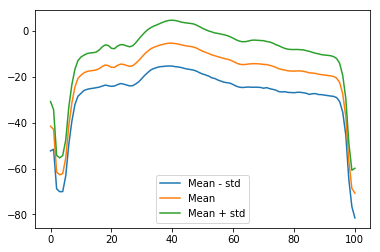

In [35]:
M=COV['Mean']
S=np.sqrt(COV['Var'])
plt.plot(M-S)
plt.plot(M)
plt.plot(M+S)
plt.legend(['Mean - std', 'Mean', 'Mean + std'])
plt.show()

## Eigen Vector Extraction

('shape of E=', (101,), 'shape of NE=', (101,))
Plot for the first 10 Eigen Vectors


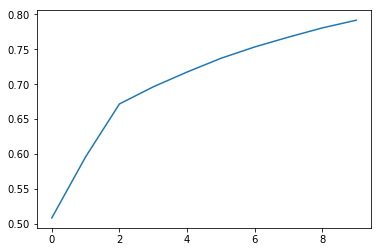

In [36]:
## Get Spectra
spectra=df_new.rdd.map(trimmed_spectra)

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction
print("Plot for the first 10 Eigen Vectors")
plot(cumsum(eigval[:10]))

In [37]:
df_new.count()

4175

## Visualizing the first 4 eigen vectors

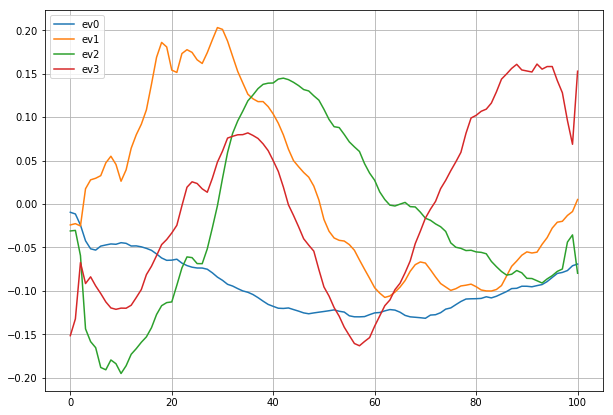

In [38]:
figure(figsize=[10,7])
for i in range(4):
    plot(eigvec[:,i],label='ev'+str(i))
legend()
grid()

In [39]:
sum(eigvec[:,1]**2)

1.0000000000000007

**Observations**: Can be seen that the sum of all eigen vectors is 1

In [40]:
## Using First 10 Eigen Vectors
V=eigvec[:,0:10]
## Defining a function to return Projection
def project(array):
    return np.dot(array, V)

## Creating Training Data

In [41]:
def calc_stats(row):
    array = trimmed_spectra(row)
    projections = project(array)
    rmse = np.std(array)
    peak2peak = row.peak2peak
    label = 0 if row.species==u'Gervais' else 1
    return np.hstack((projections, [rmse, peak2peak, label]))

In [44]:
df_trimmed_data = df_new.rdd.map(calc_stats)

In [45]:
data = df_trimmed_data.collect()

In [46]:
df_trimmed_data.count()

4175

## Writing Data

In [47]:
np_data = np.array(data)
np.save(open('data_15mb.np', 'wb'), np_data)

## Category Analysis

In [48]:
Cuviers=df_new.filter(df_new.TPWS2==1).filter(df_new.species==u'Cuviers')
Gervais=df_new.filter(df_new.TPWS2==1).filter(df_new.species==u'Gervais')

In [49]:
print("Total: ", Cuviers.count() + Gervais.count())
print("Cuviers: ", Cuviers.count())
print("Gervais: ", Gervais.count())

('Total: ', 4175)
('Cuviers: ', 2238)
('Gervais: ', 1937)


In [50]:
V=eigvec[:,1:3] #vectors on which to project, chose 1,2 eigen vectors
def project(row):
    X=unpackArray(row.MSP,data_type=np.float64)
    return np.dot(X,V)

## Scatter Plot
Scatter plot shows there are some points which are classified as a particular species in high confidence and the rest are unsure.

(0, 200)

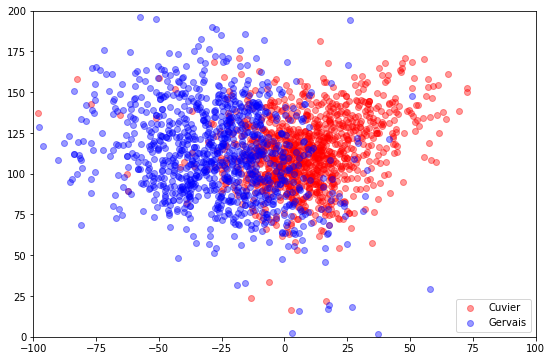

In [58]:
Cuvier_projections=np.array(Cuviers.sample(False,0.5).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.5).rdd.map(project).take(10000))

figure(figsize=[9,6])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', alpha=0.4)
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-100,100])
ylim([0,200])

## Highlighting the area of importance

(75, 150)

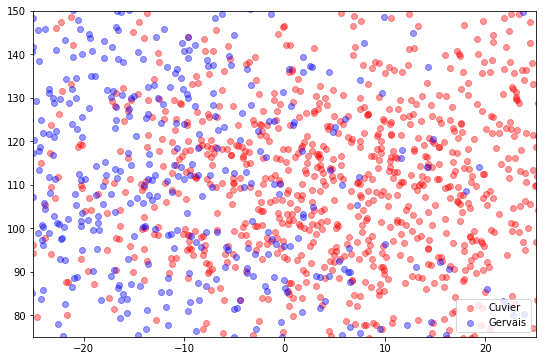

In [59]:
Cuvier_projections=np.array(Cuviers.sample(False,0.5).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.5).rdd.map(project).take(10000))


figure(figsize=[9,6])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', alpha=0.4)
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-25, 25])
ylim([75, 150])